# Training the final model

This notebook is supplementary material to the project here, which aims to re-implement the Hubble.2d6 tool to predict the function of CYP2D6 star alleles.

Within this notebook, the final model in the sequence outlined in the paper is trained using transfer learning. Weights from the first step are loaded into the new model. The fully-connected layers of the first model are replaced with new, randomly initialised layers and trained on 31 star alleles and their respective suballeles.

Please keep in mind that this implementation is incomplete due to the lack of resources to compute robust annotation embeddings of all variants for all star alleles.

Additionally, in the paper, this model is supposed to instead have its weights - along with weights of one of the fully-connected layers - loaded in from the second model in the sequence. However, due to data availability, I was unable to reproduce the implementation of the second model and instead chose to transfer just the convolution layers' weights to the final model from the first model that was trained on simulated data.

## Getting ready

**Acknowledgements**: Pre-computed annotation embeddings used are form the original Hubble.2d6 repo: https://github.com/gregmcinnes/Hubble2D6/tree/master/data

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1337)

In [3]:
!git clone https://github.com/Locrian24/seng474-term-project.git
!cd seng474-term-project/ && git pull

Cloning into 'seng474-term-project'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 119 (delta 45), reused 95 (delta 24), pack-reused 0
Receiving objects: 100% (119/119), 7.30 MiB | 19.36 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Already up to date.


In [4]:
import sys
sys.path.insert(0, '/content/seng474-term-project')

## Preparing the data

The vcf file of the star alleles used were provided from the paper and can be found **here**. 

### Encoding method

The script `build_label_csv.py` was run on this vcf file to output the label csv that will be used for training.

Labels for the data correspond to the ordinal classes describing the function of each CYP2D6 star allele and their respective suballeles: "No function", "Decreased function", and "Normal function".

The model however is required to output two scores, representing the probability of a star allele being "No function" and "Normal function" respectively, and therefore a binary scoring system is used to encode the 3 function classes into these two scores. 

The scoring system is as follows:
- "No function" alleles are indicated with a 0 as the first score, with all other functions being denoted with a 1
- "Normal function" alleles are indicated with a 1 as the second score, with all other functions being denoted with a 0.

This yields the following encodings:
- "No function" = `[0, 0]`
- "Decreased function" = `[0, 1]`
- "Normal function" = `[1, 1]`

**Note**: Star alleles with uncurated function have an empty label (`[None, None]`). 

_Sequence encodings are done exactly the same as in step 1_

In [5]:
from encode_to_seq import Encode2Seq

# Global variables rn for testing

ANNOTATIONS = '/content/seng474-term-project/data/gvcf2seq.annotation_embeddings.csv'
EMBEDDINGS = '/content/seng474-term-project/data/embeddings.txt'
REF = '/content/seng474-term-project/data/ref.seq'

VCF = '/content/seng474-term-project/step3/star_samples.vcf'
LABELS = '/content/seng474-term-project/step3/labels.csv'

encoding = Encode2Seq(vcf=VCF, labels=LABELS, label_cols=[0, 1, 2], embedding_file=EMBEDDINGS, annotation_file=ANNOTATIONS, ref_seq=REF)

### Seperation of data sets

The paper indicates that they used 31 star alleles and their suballeles as training data, and 24 alleles to compose the test data. Additionally, 10% of the each functional class ("No function", "Decreased function", and "Normal function") were held out for validation during training.

All star alleles with "Uncurated function" were ignored, and held from training/testing for obvious reasons.

In [6]:
# Select only star alleles with curated function

mask = np.all(np.isnan(encoding.y) == False, axis=1)

sample_y = encoding.y[mask]
sample_X = encoding.X[mask.reshape(-1, 1).any(axis=1)]
sample_names = encoding.sample_names[mask]

In [7]:
# Get valid stars
all_stars = np.array([s.split('_')[1] for s in sample_names])
stars, idx = np.unique(all_stars, return_index=True)

# Choose which stars are training and which are test: (31, 24) split
# Should be stratified with labels
train_idx, test_idx = train_test_split(idx, stratify=sample_y[idx], test_size=24, random_state=0)

# Retrieve indices of training and test stars
sample_mask = np.isin(all_stars, all_stars[train_idx])

test_stars = np.array([s for s in sample_names[~sample_mask] if s.split('_')[-1] == 'vcf'])
test_mask = np.isin(sample_names, test_stars)

# Split the data into the two sets - INCLUDING SUBALLES ON BOTH
# _train_X, test_X = sample_X[sample_mask], sample_X[~sample_mask]
# _train_y, test_y = sample_y[sample_mask], sample_y[~sample_mask]

_train_X, test_X = sample_X[sample_mask], sample_X[test_mask]
_train_y, test_y = sample_y[sample_mask], sample_y[test_mask]

# Split training into train + validation (10% split -> validation)
train_X, val_X, train_y, val_y = train_test_split(_train_X, _train_y, stratify=_train_y, test_size=0.1, random_state=0)

In [8]:
# Uncurated star alleles

uncurated_samples = encoding.sample_names[~mask]
uncurated_stars = np.array([s for s in uncurated_samples if s.split('_')[-1] == 'vcf'])
uncurated_star_mask = np.isin(uncurated_samples, uncurated_stars)

# uncurated_X = encoding.X[uncurated_star_idx]
# uncurated_samples = uncurated_samples[uncurated_star_idx]

uncurated_samples = uncurated_samples[uncurated_star_mask]
uncurated_X = encoding.X[(~mask).reshape(-1, 1).any(axis=1)]
uncurated_X = uncurated_X[uncurated_star_mask]

### Prepare data for the model

In [9]:
_train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_ds = _train_ds.shuffle(32).batch(32).prefetch(buffer_size=10)

_val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_y))
val_ds = _val_ds.shuffle(32).batch(32).prefetch(buffer_size=10)

_test_ds = tf.data.Dataset.from_tensors((test_X, test_y))
test_ds = _test_ds.prefetch(buffer_size=10)

## Building the final model

As stated earlier, the model is loaded from the generated model from step 1, and also inherits its learned weights.

In [10]:
epochs = 20
fine_tune_epochs = 7

def build_and_fit(train_dataset, val_dataset):
  json_file = open('/content/seng474-term-project/step_1/model.json', 'r')
  loaded_model = json_file.read()
  model = tf.keras.models.model_from_json(loaded_model)
  model.load_weights('/content/seng474-term-project/step_1/weights.h5')
  
  # Remove fully connected layers
  model.pop()
  model.pop()
  model.pop()
  model.trainable = False

  # Build final model
  inputs = tf.keras.Input(shape=(14868, 13))
  # model.training = False
  x = model(inputs, training=False)
  x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.VarianceScaling(mode='fan_avg', distribution='uniform'), name = "dense_5")(x)
  x = tf.keras.layers.Dropout(rate=0.03, name="dropout_4")(x)
  x = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, kernel_initializer=tf.keras.initializers.VarianceScaling(mode='fan_avg', distribution='uniform'), name = "dense_6")(x)
  outputs = tf.keras.layers.Dense(2, activation=tf.keras.activations.sigmoid, kernel_initializer=tf.keras.initializers.VarianceScaling(mode='fan_avg', distribution='uniform'), name = "final_dense")(x)
  final_model = tf.keras.Model(inputs, outputs)

  # Initial training
  final_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
  )

  final_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=0)

  # Fine tuning
  model.trainable = True
  # model.training = True
  final_model.compile(
      tf.keras.optimizers.Adam(1e-5),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy()]
  )

  final_model.fit(train_dataset, epochs=fine_tune_epochs, validation_data=val_dataset, verbose=0)
  
  return final_model

## Training ensemble models

Hubble.2d6 uses an ensemble averaging method for it's final predictions. Here we are training 7 models to use in the ensemble, report the training accuracy of each and save these models for the final tool.

In [11]:
ensemble_size = 7

for i in range(ensemble_size):
  model = build_and_fit(train_ds, val_ds)
  model.evaluate(train_ds)
  model.evaluate(val_ds)

  model.save(f'models/ensemble_{i}.model.h5')

1/1 [==============================] - 0s 83ms/step - loss: 0.5471 - binary_accuracy: 0.7692


Now that we have the ensemble models saved, we will use them for the final prediction.

## Building the ensemble

This step is identical to how the final implementation of this project builds the ensemble, with its purpose being here for evaluation purposes.

**Note**: In development, this notebook was run and the weights are already saved for the final model

In [12]:
class Ensemble():
  def __init__(self, X=None):
    self.X = X
    self.predictions = None

    self.run()

  def run(self):
    predictions = self.predict(self.X).mean(axis=0)
    self.predictions = self.get_functions(predictions)

  def get_functions(self, pred):
    cutpoint_1 = 0.4260022
    cutpoint_2 = 0.7360413

    cut1 = np.greater(pred[:, 0], [cutpoint_1])
    cut2 = np.greater(pred[:, 1], [cutpoint_2])

    functions = []
    for i in range(pred.shape[0]):
      if cut1[i] == True and cut2[i] == True:
        functions.append("Normal")
      elif cut1[i] == True and cut2[i] == False:
        functions.append("Decreased function")
      else:
        functions.append("No function")

    return np.array(functions) 

  def evaluate(self, y):
    labels = self.get_functions(y)

    return np.sum(labels == self.predictions) / len(y)

  def predict(self, X):
    from glob import glob
    dir = '/content/models/'
    models = glob(dir + "*.model.h5")
    
    predictions = []
    for m in models:
      print(f"Predicting using {m}")
      model = tf.keras.models.load_model(m)
      
      pred = model.predict(X)
      predictions.append(pred)

    return np.array(predictions)

In [13]:
# Training data

train_ensemble = Ensemble(train_X)
print("\nAccuracy:", train_ensemble.evaluate(train_y))

Predicting using /content/models/ensemble_4.model.h5
Predicting using /content/models/ensemble_6.model.h5
Predicting using /content/models/ensemble_0.model.h5
Predicting using /content/models/ensemble_1.model.h5
Predicting using /content/models/ensemble_2.model.h5
Predicting using /content/models/ensemble_5.model.h5
Predicting using /content/models/ensemble_3.model.h5

Accuracy: 0.9051724137931034


In [14]:
# Testing data

test_ensemble = Ensemble(test_X)
print("\nAccuracy:", test_ensemble.evaluate(test_y))

Predicting using /content/models/ensemble_4.model.h5
Predicting using /content/models/ensemble_6.model.h5
Predicting using /content/models/ensemble_0.model.h5
Predicting using /content/models/ensemble_1.model.h5
Predicting using /content/models/ensemble_2.model.h5
Predicting using /content/models/ensemble_5.model.h5
Predicting using /content/models/ensemble_3.model.h5

Accuracy: 0.7391304347826086


## Evaluation

We achieve around 90% of training accuracy, and 70% on testing data.

It is important to note that training data includes suballele annotation embeddings as well as their respective star alleles, whereas validation and test sets contain only star allele data as per the paper.

In [15]:
import seaborn as sb
import matplotlib.pyplot as plt

def build_heatmap(pred, y, labels):
  heatmap = []
  for label in labels:
    mask = pred == label
    masked_labels = y[mask]
    heatmap.append([len(masked_labels[masked_labels == l]) for l in reversed(labels)])

  return heatmap

[Text(0.5, 33.0, 'True function'), Text(0.5, 1.0, 'Test set')]

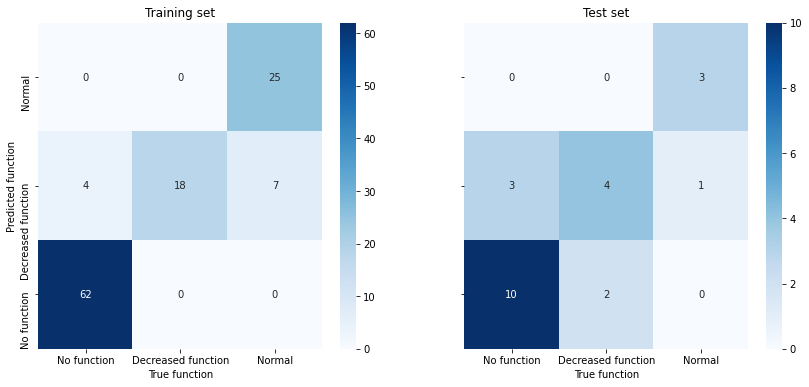

In [16]:
labels = ["Normal", "Decreased function", "No function"]

train_labels = train_ensemble.get_functions(train_y)
test_labels = test_ensemble.get_functions(test_y)

train_heatmap = build_heatmap(train_ensemble.predictions, train_labels, labels)
test_heatmap = build_heatmap(test_ensemble.predictions, test_labels, labels)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(14, 6)

sb.heatmap(train_heatmap, cmap="Blues", annot=train_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels, ax=ax1)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels, ax=ax2)

ax1.set(xlabel="True function", ylabel="Predicted function", title="Training set")
ax2.set(xlabel="True function", title="Test set")